In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

In [1]:
%cd ../functions
from trajectory import Trajectory
from simulation import simulate_data
from plotting import plot_phase, plot_t, plot_theta

/home/mffang/workspace/Trajectory/Poisson-regression/functions


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import scanpy

In [3]:
adata = scanpy.read('../data/sperm_pb.loom')#'../data/cell_RNA_gexp_sper_pb.loom')
#adata.var_names_make_unique
#adata.write_loom('../data/sperm_pb.loom')
adata

AnnData object with n_obs × n_vars = 3000 × 18255
    layers: 'matrix', 'spliced', 'unspliced'

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


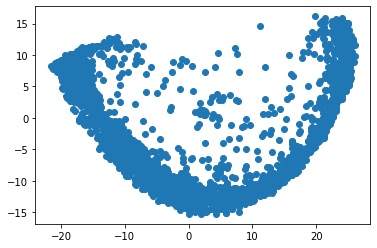

In [4]:
total_UMI = adata.X.toarray().sum(axis=1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
plt.scatter(x[:,0],x[:,1])

In [ ]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2,init='pca',learning_rate='auto').fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
plt.scatter(x_tsne[:,0],x_tsne[:,1])

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [ ]:
marker_genes=["Piwil1","Tex21","Tnp1","Cldn11","Fabp3"]
marker_idx=adata.var_names.isin(marker_genes)

In [ ]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)

idx=( ((U_mu>3) &  ((U_var/U_mu-1)/U_mu>0.1)) | ((S_mu>5) & ((S_var/S_mu-1)/S_mu>0.1)) ) | marker_idx
print(np.sum(idx))

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.log(U_mu),np.log(U_var),'.');
axs[0].plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
axs[0].plot(np.log(U_mu),np.log(U_mu));

axs[1].plot(np.log(S_mu),np.log(S_var),'.');
axs[1].plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
axs[1].plot(np.log(S_mu),np.log(S_mu));

In [ ]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [ ]:
tau=(0,0.5,1)
topo = np.array([[0,1]])
traj = Trajectory(topo, tau)
Q, elbos = traj.fit(X, n_init=3, parallel=True, n_threads=2, seed=42)

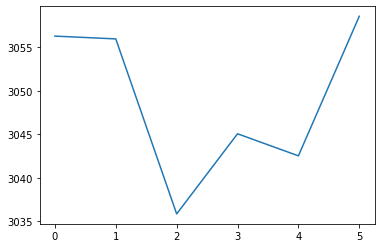

In [36]:
plt.plot(elbos)

In [37]:
plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

Index(['Fabp3', 'Cldn11', 'Tnp1', 'Piwil1', 'Tex21'], dtype='object', name='Gene')

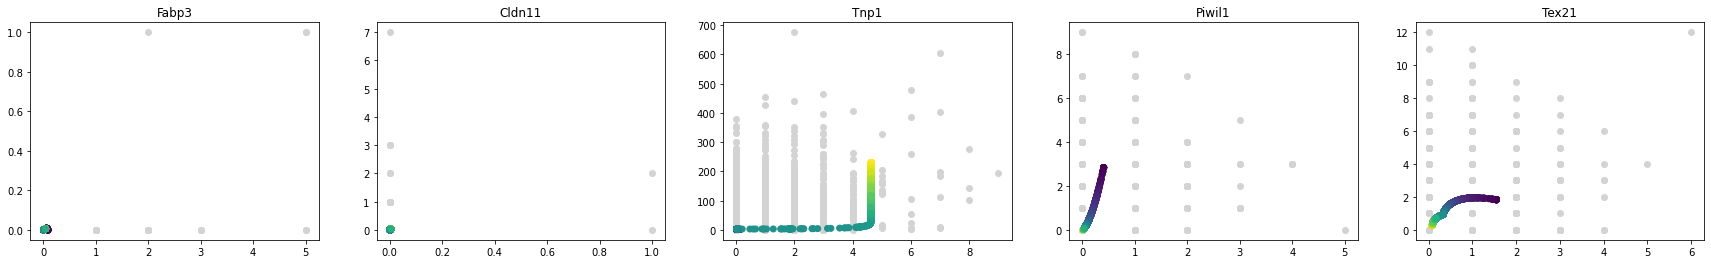

In [47]:
plot_phase(X[:,plot_idx,:],traj.theta[plot_idx,:], Q, topo, tau, gene_list[plot_idx])

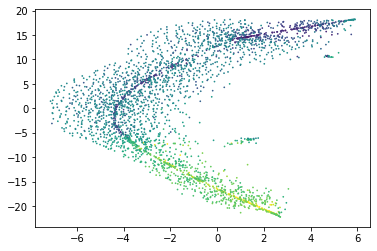

In [48]:
m=100
h=np.linspace(0,1,m)
t=np.sum(Q[:,0]*h[None,:],axis=1)
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=t,s=0.5);